In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import re

In [2]:
%%time
df_original = pd.read_csv('vehicles.csv')

CPU times: user 12.7 s, sys: 5.36 s, total: 18.1 s
Wall time: 21.7 s


# Speculate the dataset

In [3]:
df_original.head()
# choose the interesting features
df = df_original[['id', 'price', 'year', 'manufacturer', 'fuel', 'odometer', 'title_status', 'type', 'state', 'posting_date']]
for i in list(df.columns):
    print('The number of unique values in Column {} is {}'.format(i, str(len(df[i].unique()))))
print('number of rows before dropna: ', len(df))
print('precent of NaN values in all columns:\n', df.isnull().sum()/len(df))

The number of unique values in Column id is 426880
The number of unique values in Column price is 15655
The number of unique values in Column year is 115
The number of unique values in Column manufacturer is 43
The number of unique values in Column fuel is 6
The number of unique values in Column odometer is 104871
The number of unique values in Column title_status is 7
The number of unique values in Column type is 14
The number of unique values in Column state is 51
The number of unique values in Column posting_date is 381537
number of rows before dropna:  426880
precent of NaN values in all columns:
 id              0.000000
price           0.000000
year            0.002823
manufacturer    0.041337
fuel            0.007058
odometer        0.010307
title_status    0.019308
type            0.217527
state           0.000000
posting_date    0.000159
dtype: float64


# Drop rows with NaN and filter 0 < price < 150000

In [4]:
df = df[df['price'].gt(2000) & df['price'].lt(50000)]
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
print('number of rows these filtering: ', len(df))
print('precent of NaN values in all columns:\n', df.isnull().sum()/len(df))
for i in list(df.columns):
    print('The number of unique values in Column {} is {}'.format(i, str(len(df[i].unique()))))
# df.to_csv('Kaggle used car cleaned.csv', index=False)

number of rows these filtering:  266971
precent of NaN values in all columns:
 id              0.0
price           0.0
year            0.0
manufacturer    0.0
fuel            0.0
odometer        0.0
title_status    0.0
type            0.0
state           0.0
posting_date    0.0
dtype: float64
The number of unique values in Column id is 266971
The number of unique values in Column price is 10808
The number of unique values in Column year is 103
The number of unique values in Column manufacturer is 42
The number of unique values in Column fuel is 5
The number of unique values in Column odometer is 76952
The number of unique values in Column title_status is 6
The number of unique values in Column type is 13
The number of unique values in Column state is 51
The number of unique values in Column posting_date is 239004


# Other filtering and Categorical Encoding

According to the visualization:
Year and Median Odometer are related and both correlate well with Median Price
Type, Manufacturer, and Fuel make the Median Price - Median Odometer curve more dispersed
State doesn't make the Median Price - Median Odometer curve more dispersed
Title Status needs to be filtered.


price = f(manufacturer, fuel, odometer, type)

In [5]:
df = df[df['title_status'] == 'clean']
df = df[['price', 'manufacturer', 'fuel', 'odometer', 'type', 'state', 'year']]
df.reset_index(inplace = True, drop = True)
df.head()

,price,manufacturer,fuel,odometer,type,state,year
0,33590,gmc,gas,57923.0,pickup,al,2014.0
1,22590,chevrolet,gas,71229.0,pickup,al,2010.0
2,39590,chevrolet,gas,19160.0,pickup,al,2020.0
3,30990,toyota,gas,41124.0,pickup,al,2017.0
4,15000,ford,gas,128000.0,truck,al,2013.0


In [6]:
ProfileReport(df)

/Users/junqingzhu/opt/anaconda3/envs/combustion/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,7
Number of observations,258766
Total Missing (%),0.0%
Total size in memory,13.8 MiB
Average record size in memory,56.0 B
Numeric,3
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [6]:
df_year_group = df.groupby(['year']).median()
df_year_group_count = df.groupby(['year']).count()

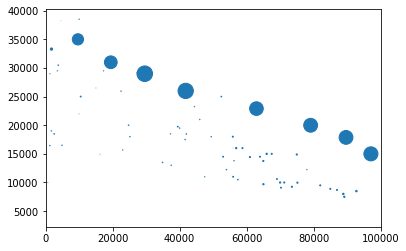

In [7]:
# plot the median odometer and median price of each year with count of row as the size
%matplotlib inline
plt.scatter(df_year_group['odometer'], df_year_group['price'], s = df_year_group_count['price']/100)
plt.xlim(0, 100000)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [9]:
y = df['price']
X = df.drop(columns = ['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [11]:
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
print(object_cols)
df['manufacturer'].unique()

['manufacturer', 'fuel', 'type', 'state']


array(['gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
       'mazda', 'cadillac', 'honda', 'lexus', 'jaguar', 'buick',
       'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
       'subaru', 'acura', 'hyundai', 'mercedes-benz', 'bmw', 'mitsubishi',
       'volkswagen', 'porsche', 'kia', 'rover', 'pontiac', 'dodge',
       'fiat', 'tesla', 'mini', 'saturn', 'mercury', 'harley-davidson',
       'datsun', 'aston-martin', 'land rover', 'morgan', 'ferrari'],
      dtype=object)

In [12]:
label_X_train = X_train.copy()
label_X_test = X_test.copy()
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_test[object_cols] = ordinal_encoder.fit_transform(X_test[object_cols])

# Speculate the correlation matrix

In [13]:
label_all = df.copy()
label_all[object_cols] = ordinal_encoder.fit_transform(df[object_cols])
label_all.head()

,price,manufacturer,fuel,odometer,type,state,year
0,33590,14.0,2.0,57923.0,8.0,1.0,2014.0
1,22590,7.0,2.0,71229.0,8.0,1.0,2010.0
2,39590,7.0,2.0,19160.0,8.0,1.0,2020.0
3,30990,39.0,2.0,41124.0,8.0,1.0,2017.0
4,15000,13.0,2.0,128000.0,10.0,1.0,2013.0


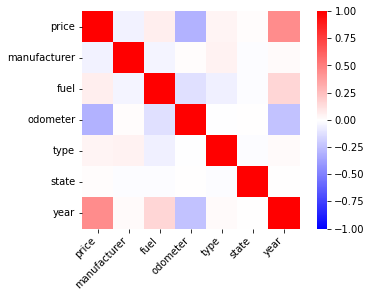

In [14]:
%matplotlib inline
import seaborn as sns
corr = label_all.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0, cmap = 'bwr',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

# Define a plot function for data visualization

In [15]:
def plot_target_and_prediction(reg, X_test, y_test):
    import matplotlib.pyplot as plt
    y_test_pred = reg.predict(X_test)
    plt.scatter(y_test, y_test_pred, marker= 'o')
    plt.plot(y_test, y_test, 'r-')
    plt.title('R2 ={}'.format(reg.score(X_test, y_test)))
    plt.xlabel('Target price (y)')
    plt.ylabel('Predicted price (y_pred)')
    plt.tight_layout()
    plt.show()

# Try different regressor

## XGBoost

In [18]:
# def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='rmse', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(X_train, y_train,eval_metric='rmse')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(X_train)
        
#     #Print model report:
#     print ("\nModel Report")
#     print ("Accuracy : %.4g") % metrics.accuracy_score(y_train.values, dtrain_predictions)
#     print ("Mean Abosolute Error : %.4g") % mean_absolute_error(y_train.values, dtrain_predictions)               
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [40]:
def model_fit(reg, X_train, y_train, X_test, y_test, cv = False):
    from sklearn.metrics import mean_absolute_error, r2_score
    reg.fit(X_train,y_train)
    print ('\nModel Report')
    print('R2 of the training set:', round(r2_score(reg.predict(X_train), y_train), 4))
    print('R2 of the testing set:', round(r2_score(reg.predict(X_test), y_test), 4))
    print('MAE of the training set:', round(mean_absolute_error(reg.predict(X_train), y_train), 4))
    print('MAE of the testing set:', round(mean_absolute_error(reg.predict(X_test), y_test), 4))
    if cv:
        from sklearn.model_selection import cross_val_score
        print(cross_val_score(reg, X_train, y_train, scoring='r2'))
    plot_target_and_prediction(xg_reg, X_test, y_test)
#     reg.plot_importance(reg)

In [48]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, gamma = 0.2, n_estimators = 100, min_child_weight = 10)

In [49]:
from sklearn.model_selection import GridSearchCV 
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xg_reg, param_grid = param_test1, scoring='r2', cv=3)
gsearch1.fit(label_X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 3}, 0.8501026493014342)

In [50]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 9, gamma = 0.2, n_estimators = 100, min_child_weight = 3)

In [55]:
param_test2 = {
 'max_depth':range(15,31,5)
}
gsearch2 = GridSearchCV(estimator = xg_reg, param_grid = param_test2, scoring='r2', cv=3)
gsearch2.fit(label_X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 20}, 0.8900476399020415)

In [56]:
model_fit(gsearch2.best_estimator_, label_X_train, y_train, label_X_test, y_test)


Model Report
R2 of the training set: 0.9884
R2 of the testing set: 0.743
MAE of the training set: 692.555
MAE of the testing set: 3620.1678


NotFittedError: need to call fit or load_model beforehand

## linear regression

In [31]:
from sklearn.linear_model import LinearRegression
linreg= LinearRegression().fit(label_X_train, y_train)
print(label_X_train.head())
print(y_train.head())

        manufacturer  fuel  odometer  type  state    year
40993           20.0   2.0  141000.0   0.0    4.0  2007.0
167827          23.0   2.0    6462.0   4.0   34.0  2018.0
122328           7.0   2.0   53486.0   0.0   22.0  2012.0
249876          13.0   2.0  111173.0   0.0   47.0  2014.0
21293           13.0   2.0   78399.0   7.0    4.0  2012.0
40993     15995
167827    31590
122328    13900
249876    10495
21293     20195
Name: price, dtype: int64


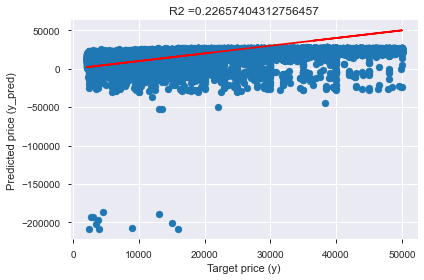

In [32]:
plot_target_and_prediction(linreg, label_X_test, y_test)
# type(linreg.score(label_X_test, y_test))
# type(linreg.score(label_X_train, y_train))

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
rf_reg = RandomForestRegressor(max_features = 3, random_state=0).fit(label_X_train, y_train)
print(rf_reg.score(label_X_train, y_train))
print(rf_reg.score(label_X_test, y_test))
print(mean_absolute_error(rf_reg.predict(label_X_test), y_test))

0.9865099816627111
0.8073387489701136
3488.4261903948823


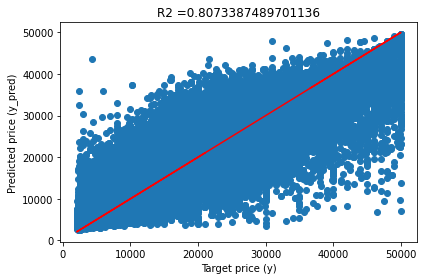

In [173]:
plot_target_and_prediction(rf_reg, label_X_test, y_test)

# Try GridSearchCV

In [158]:
from sklearn.model_selection import GridSearchCV # default cv fold = 3
from sklearn.metrics import r2_score, SCORERS, mean_absolute_error
parameters = {'max_features': [2, 3, 4], 'n_estimators': [5, 10, 15]}
reg = RandomForestRegressor()
# sorted(SCORERS.keys())
reg_grid = GridSearchCV(reg, param_grid = parameters, scoring = 'neg_mean_absolute_error')
reg_grid.fit(label_X_train, y_train)
reg_best = reg_grid.best_estimator_

0.9731320608885767
0.8281942133564741
2976.0160519688925


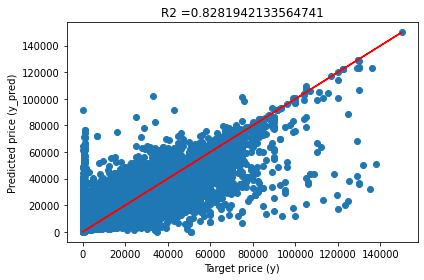

In [161]:
print(reg_best.score(label_X_train, y_train))
print(reg_best.score(label_X_test, y_test))
print(mean_absolute_error(reg_best.predict(label_X_test), y_test))
plot_target_and_prediction(reg_best, label_X_test, y_test)